In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, poisson
from scipy.optimize import curve_fit
from scipy.special import factorial

## Thermal Evolution of a Cooking Kernel

In [2]:
# Important constants
M = 0.018 #kg/mol
Lv = 2.3e6 #J/kg
To = 373 #K
po = 1e5 #Pa
Rr = 8.3 #J/mol K
sigc = 10e6 #Pa
cp = 2000 #J/kg
gam = 1.3

In [3]:
# Define kernel parameters (average)
k = 0.1745 # W/mK
rho = 1240 #kg/m^3
radius = 5e-3 #m
ht = 160e-6

# Calculate kernel diffusivity and critical temperature
alpha = k/(cp * rho)
pc=2*ht / radius * sigc
rfinal = (pc/po)**(1/(3*gam)) * radius
popping_temp = To / (1 - (Rr * To/ (M*Lv) * np.log(pc/po) ))
oil_temp = 460

In [4]:
# Divide kernel into N layers and define grid of radius values
N = 1000
R , dr = np.linspace(-radius, radius, N, retstep=True)

# Create a matrix to define the sytem of coupled ODEs
C = np.zeros(shape=(N, N))
for i in range(1, N - 1):
        r = R[i]
        C[i][i - 1] = -(1/dr**2 - 1/(r * dr))
        C[i][i] = 2 / dr**2
        C[i][i + 1] = -(1/dr**2 + 1/(r * dr))
C *= alpha

In [5]:
# Define a timestep and step count
dt = 0.2
nsteps = 1000
t = dt * np.arange(nsteps)

In [6]:
# Initalize a grid to record the evolution of the kernels temperature at different layers
Temperatures = np.full((nsteps, N), 293, dtype=float)

# Set first row to boundary conditions
Temperatures[:,0]  = oil_temp
Temperatures[:,-1]  = oil_temp

In [7]:
# Perform the backwards Euler method to update the temperature array at each timestep
A = np.linalg.inv(np.identity(N) + dt*C)

for i in range(1,nsteps):
    Temperatures[i] = A@Temperatures[i-1]
    
    # Terminate solver when the internal temperature of the kernel reaches critical temperature; the kernel pops
    if Temperatures[i, N//2]>= popping_temp:
        Temperatures = Temperatures[:i]
        pop_time = i*dt
        print("Kernel Pops at t=", pop_time, 's')
        break       

Kernel Pops at t= 91.0 s


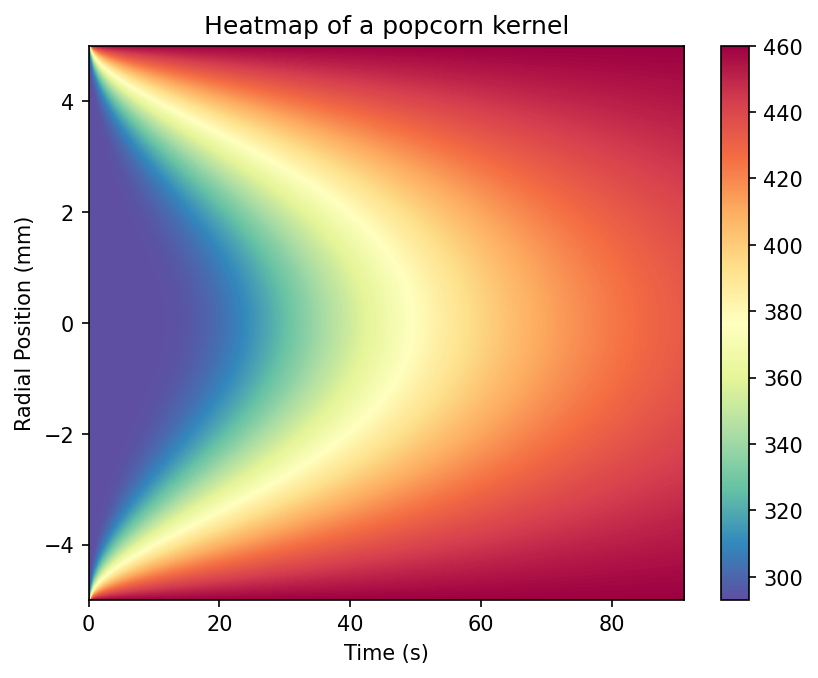

In [8]:
# Plot color map of temperature distribution in diameter of kernel through time

plt.figure(dpi=150)
extent = (0, pop_time, -radius*1000, radius*1000)
plt.imshow(Temperatures.T, aspect='auto', origin='lower', cmap='Spectral_r', extent=extent)
plt.title('Heatmap of a popcorn kernel')
plt.ylabel('Radial Position (mm)')
plt.xlabel('Time (s)')
plt.colorbar()
plt.show()

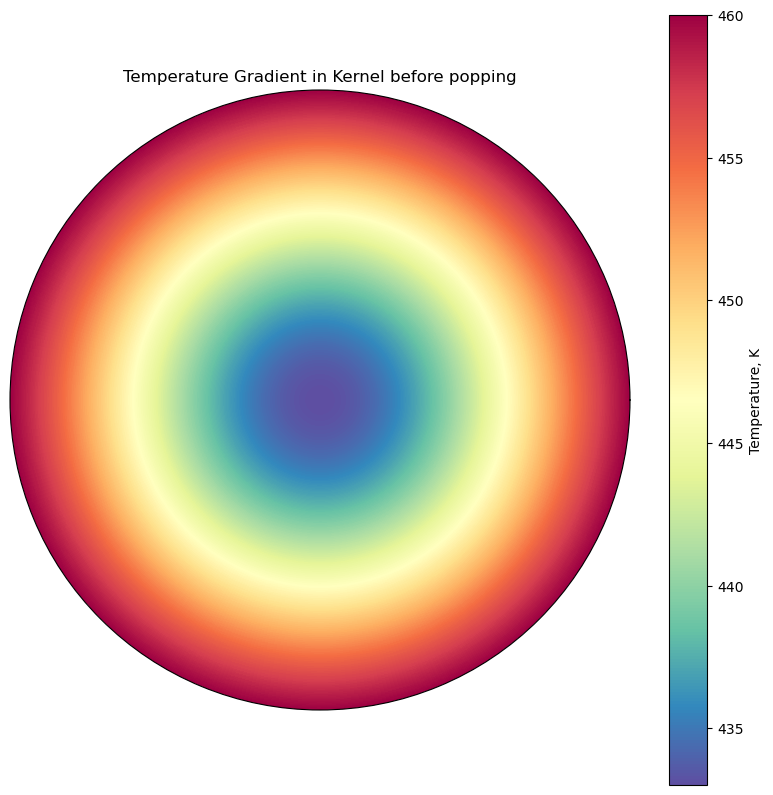

In [9]:
# Extract last row and trim duplicate temperatures at negative radius
radial_temperatures = Temperatures[-1, R>0]

# Plot polar colour map of temperature distribution before popping

nrings = N//2 # Number of radial temperature values

# plot over mesh grid in r and theta
r = np.linspace(0, radius, nrings)
theta = np.linspace(0, 2 * np.pi, nrings)
r_grid, theta_grid = np.meshgrid(r, theta)

# Create a grid of temperatures
temperature_grid = np.tile(radial_temperatures, (nrings, 1))  

# plot
plt.figure(figsize=(10, 10))
plt.subplot(111, projection='polar')
plt.pcolormesh(theta_grid, r_grid, temperature_grid, cmap='Spectral_r')
plt.colorbar(label='Temperature, K')
plt.rgrids([])
plt.thetagrids([]) 
plt.title('Temperature Gradient in Kernel before popping')
plt.show()

## Code Test; Stepsize Scaling

In [10]:
# compare how the internal temperature of the kernel at the 100s time changes at different temperatures

# Define a range of timesteps and step counts
dt = np.logspace(-3, 1, 30)
nsteps = 100 / dt
coretemp = np.zeros_like(dt)


# Calculate internal temerature after 100s for each timstep
for i in range(len(dt)):
    
    # perform the backwards Euler method to update the temperature array at each timestep
    A = np.linalg.inv(np.identity(N) + dt[i]*C)
    
    # Initalize a grid to record the evolution of the kernels temperature at different layers
    Temperatures = np.full(N, 293, dtype=float)
    # Set first row to initial conditions
    Temperatures[0]  = oil_temp
    Temperatures[-1]  = oil_temp

    for j in range(1, int(nsteps[i])):
        Temperatures = A@Temperatures
    
    coretemp[i] = Temperatures[N//2]

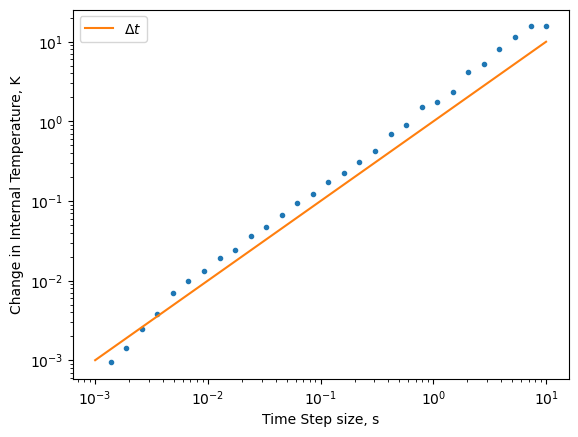

In [11]:
# Plot change from most accurate value
plt.plot(dt, abs(coretemp-coretemp[0]), '.')
plt.plot(dt, dt, label="$\Delta t$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Change in Internal Temperature, K')
plt.xlabel('Time Step size, s')
plt.legend()

In [12]:
# compare how the internal temperature of the kernel at the 100s time changes with different dr's

# Define a timestep and step count
dt = 0.2
nsteps = int(100/dt)

# Define a range of nlayers into which the kernel is divided
nlayers = np.logspace(1, 3, 40, dtype=int)
nlayers = np.array([x for x in nlayers if x % 2 == 0]) # remove any n's that yeild r=0 to avoid division by zero

coretemp = np.zeros(len(nlayers))
delta_r = 2 * radius / nlayers

# Calculate internal temerature after 100s for each number of layers

for N in nlayers:
    R , dr = np.linspace(-radius, radius, N, retstep=True)

    C = np.zeros(shape=(N, N))
    for i in range(1, N - 1):
        r = R[i]
        C[i][i - 1] = -(1/dr**2 - 1/(r * dr))
        C[i][i] = 2 / dr**2
        C[i][i + 1] = -(1/dr**2 + 1/(r * dr))
    C *= alpha

    
    # Initalize a grid to record the evolution of the kernels temperature at different layers
    Temperatures = np.full(N, 293, dtype=float)
    # Set first row to initial conditions
    Temperatures[0]  = oil_temp
    Temperatures[-1]  = oil_temp

    A = np.linalg.inv(np.identity(N) + dt*C)
    for i in range(1, nsteps):
        Temperatures = A@Temperatures
    
    coretemp[N==nlayers] = Temperatures[N//2]

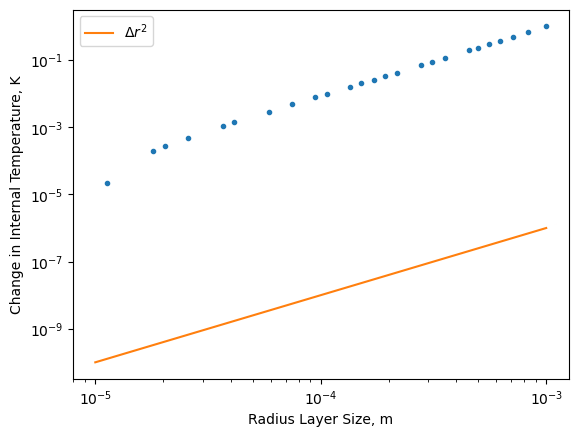

In [13]:
# plot
plt.plot(delta_r, abs(coretemp-coretemp[-1]), '.')
plt.plot(delta_r, delta_r**2, label="$\Delta r^2$")
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Change in Internal Temperature, K')
plt.xlabel('Radius Layer Size, m')
plt.legend()

# Histograms

In [17]:
M = 0.018
Lv = 2.3e6
To = 373
po=1e5
Rr = 8.3
sigc = 10e6
cp = 2000 #J/kg

nbker = 1000

# Moisture level is 15% +- 1.5
# Rho is affected by moisture by rho-10(moisture) where moisture is the level in percentage

rho = np.random.normal(loc = 1240, scale = 15, size = nbker)
ht = np.random.normal(loc=160e-6, scale = 40e-6, size = nbker) #hull thickness (m) 
k = np.random.normal(loc=0.1745, scale=0.0125, size=nbker) # thermal conductivity W/mK

radius = np.random.normal(loc=5e-3, scale=1e-3, size=nbker) # m
gam = 1.3

In [18]:
alpha = k/(cp * rho)
pc=2*ht / radius * sigc
rfinal = (pc/po)**(1/(3*gam)) * radius
popping_temp = To / (1 - (Rr * To/ (M*Lv) * np.log(pc/po) ))
oil_temp = 465
room_temp = 293
N = 1000
pop_time = np.zeros(nbker)
for x in range(nbker):
    # Define grid size
    R , dr = np.linspace(-radius[x], radius[x], N, retstep=True)


    # Create a matrix to define the sytem of coupled ODEs
    C = np.zeros(shape=(N, N))
    for i in range(1, N - 1):
            r = R[i]
            C[i][i - 1] = -(1/dr**2 - 1/(r * dr))
            C[i][i] = 2 / dr**2
            C[i][i + 1] = -(1/dr**2 + 1/(r * dr))

    C *= alpha[x]

    # Define a timestep and step count
    dt = 0.2
    nsteps =3000
    t = dt * np.arange(nsteps)

    # Initalize a grid to record the evolution of the kernels temperature at different layers
    # Set first row to initial conditions
    Temperatures = np.full((nsteps, N), room_temp, dtype='float')
    Temperatures[:,0]  = oil_temp
    Temperatures[:,-1]  = oil_temp


    # perform the backwards Euler method to update the temperature array at each timestep
    A = np.linalg.inv(np.identity(N) + dt*C)
    for i in range(1,nsteps):
        Temperatures[i] = A@Temperatures[i-1]
    
        if Temperatures[i, N//2]>= popping_temp[x]:
            Temperatures = Temperatures[:i]
            pop_time[x] = i*dt
            break

In [19]:
print("unpopped:", len(np.where(pop_time==0)[0])/nbker * 100, "%")

unpopped: 0.8 %


Gaussian Parameters are: [459.51504532   1.33680131   7.93041078]


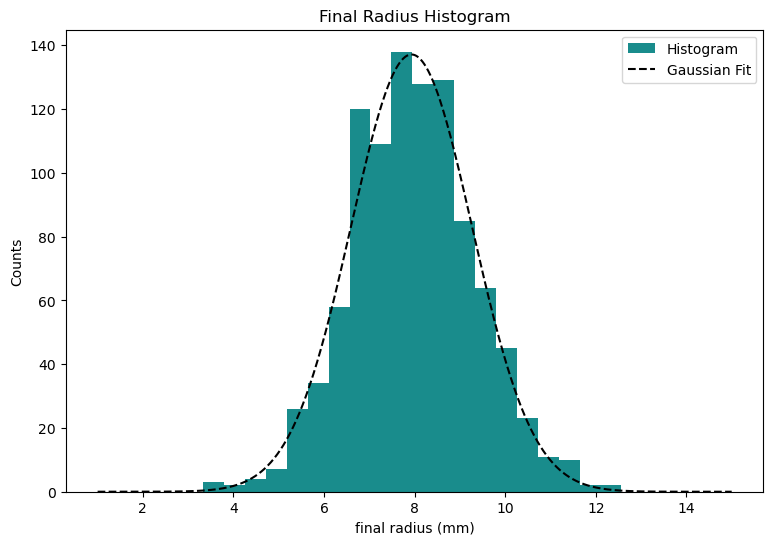

In [21]:
plt.figure(figsize = (9,6))

hist, bin_edges, _ = plt.hist(rfinal*1000, bins = 20, density = False, alpha = 0.9, label = 'Histogram', color='teal')

plt.xlabel('final radius (mm)')
plt.ylabel('Counts')
plt.title('Final Radius Histogram')


bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


def gaussian(x, A, std, mean):
    return (A / ( std * np.sqrt(2 * np.pi))) * np.exp((- 1 / 2) * ((x-mean) / std) ** 2)


def poisson(x, A, mean):
    return (A * (mean ** x) * np.exp(- mean)) / factorial(x) 


params_gaussian, _ = curve_fit(gaussian, bin_centers, hist, p0 = [1, 1, 5])
print("Gaussian Parameters are:", params_gaussian)

x = np.linspace(1, 15, 1000)


plt.plot(x, gaussian(x, *params_gaussian), c='k', ls='--', label='Gaussian Fit')


plt.legend()
plt.savefig('finalrad.png')
plt.show()


Gaussian Parameters are: [8821.5168227    28.24545184   84.18611568]


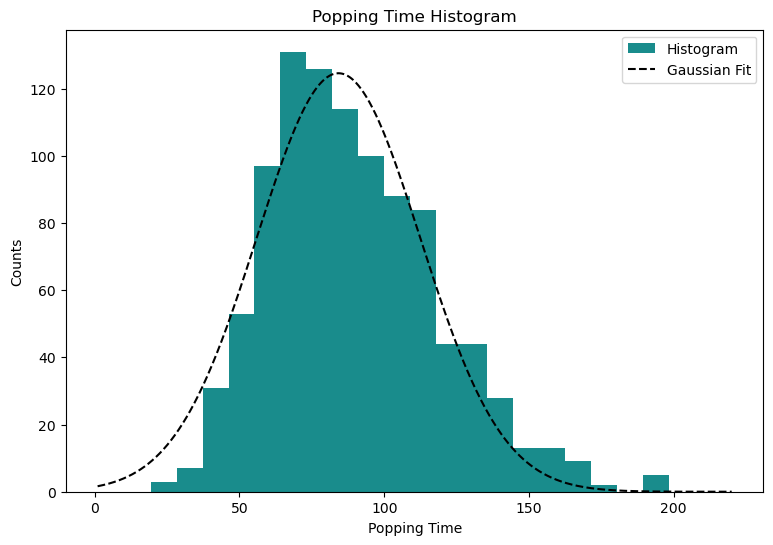

In [22]:
plt.figure(figsize = (9,6))

pop_time2 = pop_time[np.where(pop_time!=0)[0]]
hist2, bin_edges2, _ = plt.hist(pop_time2, bins = 20, density = False, alpha = 0.9,color='teal' ,label = 'Histogram')
bin_centers2 = (bin_edges2[:-1] + bin_edges2[1:]) / 2

params_gaussian2, _ = curve_fit(gaussian, bin_centers2, hist2, p0 =  [10, 10, 10])

print("Gaussian Parameters are:", params_gaussian2)

x = np.linspace(1, 220, 1000)
plt.plot(x, gaussian(x, *params_gaussian2), c='k', ls='--', label='Gaussian Fit')


plt.legend()
plt.xlabel('Popping Time')
plt.ylabel('Counts')
plt.title('Popping Time Histogram')
plt.savefig('poptime.png')
plt.show()